# Deteksi suara

## Data Voice

Sementara disini saya memakai 20 voice
- 5 voice 'buka' tanpa noice
- 5 voice 'buka' dengan noice
- 5 voice 'tutup' tanpa noice
- 5 voice 'tutup' dengan noice

Install library terlebih dahulu

In [4]:
!pip install librosa


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


## Ekstrak voice dan jadikan CSV

In [9]:
# Import library
import librosa
import pandas as pd
import numpy as np
import os
from scipy.stats import skew, kurtosis

# --- Fungsi Ekstraksi (Tidak berubah) ---
def ekstrak_fitur(file_audio):
    """
    Memuat file audio dan mengekstrak fitur statistik time series.
    """
    try:
        y, sr = librosa.load(file_audio, sr=None)
        y, _ = librosa.effects.trim(y, top_db=20)

        # Fitur Statistik
        zcr_mean = np.mean(librosa.feature.zero_crossing_rate(y))
        zcr_std = np.std(librosa.feature.zero_crossing_rate(y))
        rms_mean = np.mean(librosa.feature.rms(y=y))
        rms_std = np.std(librosa.feature.rms(y=y))
        amp_mean = np.mean(y)
        amp_std = np.std(y)
        amp_var = np.var(y)
        amp_skew = skew(y)
        amp_kurtosis = kurtosis(y)
        amp_min = np.min(y)
        amp_max = np.max(y)

        return [
            zcr_mean, zcr_std, rms_mean, rms_std,
            amp_mean, amp_std, amp_var, amp_skew,
            amp_kurtosis, amp_min, amp_max
        ]

    except Exception as e:
        print(f"Error memproses {file_audio}: {e}")
        return None

# --- Program Utama (Path Sudah Disesuaikan) ---

# Path untuk MEMBACA audio (tetap sama)
base_path = '/workspaces/PSD/psd/voice'
folder_buka = os.path.join(base_path, 'buka')
folder_tutup = os.path.join(base_path, 'tutup')

# Path untuk MENYIMPAN CSV (diubah sesuai permintaan Anda)
output_file = '/workspaces/PSD/psd/voice/fitur_audio.csv'

daftar_fitur = []
nama_kolom = [
    'zcr_mean', 'zcr_std', 'rms_mean', 'rms_std',
    'amp_mean', 'amp_std', 'amp_var', 'amp_skew',
    'amp_kurtosis', 'amp_min', 'amp_max', 'label'
]

print("Mulai memproses folder 'buka'...")
for file_name in os.listdir(folder_buka):
    file_path = os.path.join(folder_buka, file_name)
    if file_path.endswith(('.wav', '.mp3')):
        fitur = ekstrak_fitur(file_path)
        if fitur:
            fitur.append('buka')
            daftar_fitur.append(fitur)

print("Mulai memproses folder 'tutup'...")
for file_name in os.listdir(folder_tutup):
    file_path = os.path.join(folder_tutup, file_name)
    if file_path.endswith(('.wav', '.mp3')):
        fitur = ekstrak_fitur(file_path)
        if fitur:
            fitur.append('tutup')
            daftar_fitur.append(fitur)

# Buat DataFrame dan Simpan ke CSV di Google Drive
df_fitur = pd.DataFrame(daftar_fitur, columns=nama_kolom)
df_fitur.to_csv(output_file, index=False)

print("\n--- Selesai! ---")
print(f"Berhasil memproses {len(df_fitur)} file audio.")
# Menampilkan lokasi penyimpanan yang baru
print(f"File 'fitur_audio.csv' telah disimpan di: {output_file}")

# Tampilkan 5 baris pertama data Anda
print("\nContoh 5 baris pertama data Anda:")
print(df_fitur.head())

Mulai memproses folder 'buka'...
Mulai memproses folder 'tutup'...

--- Selesai! ---
Berhasil memproses 20 file audio.
File 'fitur_audio.csv' telah disimpan di: /workspaces/PSD/psd/voice/fitur_audio.csv

Contoh 5 baris pertama data Anda:
   zcr_mean   zcr_std  rms_mean   rms_std  amp_mean   amp_std   amp_var  \
0  0.018820  0.013148  0.025483  0.022131 -0.001348  0.033874  0.001147   
1  0.018971  0.012006  0.025974  0.023266 -0.001205  0.034988  0.001224   
2  0.018145  0.011967  0.028061  0.025745 -0.001882  0.038281  0.001465   
3  0.033111  0.017141  0.028010  0.022390 -0.001021  0.035917  0.001290   
4  0.023042  0.015741  0.024643  0.027912 -0.000756  0.037470  0.001404   

   amp_skew  amp_kurtosis   amp_min   amp_max label  
0  0.758647      6.041412 -0.183945  0.226974  buka  
1  0.165836      5.223163 -0.154526  0.194962  buka  
2  0.468255      8.944839 -0.228195  0.246582  buka  
3  1.011892      5.268708 -0.173523  0.198486  buka  
4 -0.110045     15.431116 -0.284241  0.27

## Testing dan Training data dengan Random Forest

- data testing 20%
- data training 80 %

Karena data masih terlalu kecil mungkin hasil prediksi tidak selalu benar

Total data: 20
Data latih: 16
Data tes: 4
---
Model berhasil dilatih.
---
Akurasi Model: 50.00%
---
Laporan Klasifikasi:
              precision    recall  f1-score   support

        buka       0.50      0.50      0.50         2
       tutup       0.50      0.50      0.50         2

    accuracy                           0.50         4
   macro avg       0.50      0.50      0.50         4
weighted avg       0.50      0.50      0.50         4

---
Confusion Matrix:


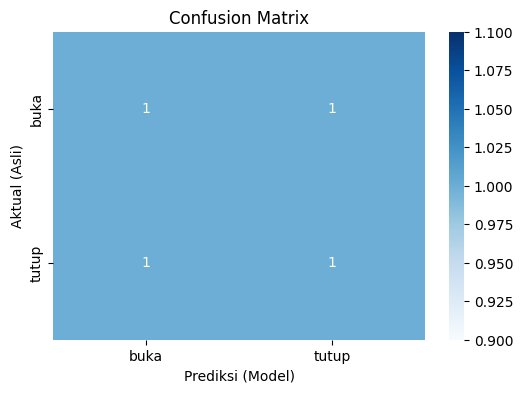

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- 1. Muat Dataset Fitur Anda ---
file_path = '/workspaces/PSD/psd/voice/fitur_audio.csv'
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"ERROR: File tidak ditemukan di {file_path}")
    print("Pastikan cell sebelumnya berhasil dijalankan dan file CSV sudah ada.")
    # Stop eksekusi jika file tidak ada
    raise

# --- 2. Persiapan Data ---

# Pisahkan Fitur (X) dan Label (y)
X = df.drop('label', axis=1)
y = df['label']

# Encode Label (Mengubah 'buka' -> 0, 'tutup' -> 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scaling Fitur (Penting untuk model ML)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Bagi Data (Train & Test) ---
# test_size=0.2 berarti 20% data untuk tes (4 file), 80% untuk latih (16 file)
# stratify=y_encoded memastikan data tes punya proporsi 'buka' dan 'tutup' yang seimbang
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Total data: {len(df)}")
print(f"Data latih: {len(X_train)}")
print(f"Data tes: {len(X_test)}")
print("---")

# --- 4. Latih Model Random Forest ---
# n_estimators=50 adalah jumlah 'pohon' di dalam 'hutan'
# random_state=42 agar hasilnya bisa diulangi
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

print("Model berhasil dilatih.")
print("---")

# --- 5. Evaluasi Model ---
y_pred = model.predict(X_test)

# Mengubah kembali prediksi (0, 1) ke label asli ('buka', 'tutup')
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Hitung Akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model: {accuracy * 100:.2f}%")
print("---")

# Tampilkan Laporan Klasifikasi
print("Laporan Klasifikasi:")
print(classification_report(y_test_labels, y_pred_labels, zero_division=0))
print("---")

# Tampilkan Confusion Matrix (Peta Error)
print("Confusion Matrix:")
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Aktual (Asli)')
plt.xlabel('Prediksi (Model)')
plt.show()

## Menyimpan dan Menguji Model

In [ ]:
import joblib

# --- 1. Tentukan Lokasi Penyimpanan ---
# Kita simpan semuanya di folder '/content/drive/MyDrive/voice/'
base_path = '/workspaces/PSD/psd/voice'
model_path = os.path.join(base_path, 'audio_model.joblib')
scaler_path = os.path.join(base_path, 'audio_scaler.joblib')
encoder_path = os.path.join(base_path, 'audio_encoder.joblib')

# --- 2. Simpan 3 Aset ---
joblib.dump(model, model_path)      # Menyimpan model Random Forest
joblib.dump(scaler, scaler_path)    # Menyimpan StandardScaler
joblib.dump(le, encoder_path)       # Menyimpan LabelEncoder

print(f"Model berhasil disimpan di: {model_path}")
print(f"Scaler berhasil disimpan di: {scaler_path}")
print(f"Encoder berhasil disimpan di: {encoder_path}")


Model berhasil disimpan di: /workspaces/PSD/psd/voice/audio_model.joblib
Scaler berhasil disimpan di: /workspaces/PSD/psd/voice/audio_scaler.joblib
Encoder berhasil disimpan di: /workspaces/PSD/psd/voice/audio_encoder.joblib


## Hasil Deploy

Bisa diakses melalui https://voice-deteksi.streamlit.app/